In [43]:
import time
import ccxt
from time import gmtime, strftime
import datetime
import pandas as pd
import talib
%matplotlib inline
print(ccxt.exchanges)

['aax', 'acx', 'aofex', 'bequant', 'bibox', 'bigone', 'binance', 'binanceus', 'bit2c', 'bitbank', 'bitbay', 'bitcoincom', 'bitfinex', 'bitfinex2', 'bitflyer', 'bitforex', 'bitget', 'bithumb', 'bitkk', 'bitmart', 'bitmax', 'bitmex', 'bitpanda', 'bitso', 'bitstamp', 'bitstamp1', 'bittrex', 'bitvavo', 'bitz', 'bl3p', 'bleutrade', 'braziliex', 'btcalpha', 'btcbox', 'btcmarkets', 'btctradeua', 'btcturk', 'buda', 'bw', 'bybit', 'bytetrade', 'cdax', 'cex', 'chilebit', 'coinbase', 'coinbaseprime', 'coinbasepro', 'coincheck', 'coinegg', 'coinex', 'coinfalcon', 'coinfloor', 'coingi', 'coinmarketcap', 'coinmate', 'coinone', 'coinspot', 'crex24', 'currencycom', 'delta', 'deribit', 'digifinex', 'dsx', 'equos', 'eterbase', 'exmo', 'exx', 'fcoin', 'fcoinjp', 'flowbtc', 'foxbit', 'ftx', 'gateio', 'gemini', 'gopax', 'hbtc', 'hitbtc', 'hollaex', 'huobijp', 'huobipro', 'idex', 'independentreserve', 'indodax', 'itbit', 'kraken', 'kucoin', 'kuna', 'lakebtc', 'latoken', 'lbank', 'liquid', 'luno', 'lykke', '

In [2]:
exchange = ccxt.binance()

In [13]:
def get_bar_from_to(ex,symbol,period,start_time,end_time,length=2000,max_loop=20):
    data = []
    stime = ex.parse8601(start_time)
    etime = ex.parse8601(end_time)
    loop_i = 0
    if ex.has['fetchOHLCV']:
        while stime < etime and loop_i < max_loop:
            loop_i += 1
            try:
                ohlcvs = ex.fetch_ohlcv(symbol,period,stime,limit=length)
                print(ex.iso8601(ex.milliseconds()),'loop_i',loop_i,', Fetched', len(ohlcvs),'candles')
                if len(ohlcvs) > 1:
                    first = ohlcvs[0][0]
                    last = ohlcvs[-1][0]
                    print('[',ex.iso8601(first),'--', ex.iso8601(last),']')
                    stime = int(last+(last-first)/(len(ohlcvs)-1))
                    data += ohlcvs
                    time.sleep(1)
                else:
                    return data
            except Exception as e:
                print(str(e))
    return data

def get_data_df(ex,symbol,period,start_time,end_time,length=2000,max_loop=20):
    data = get_bar_from_to(exchange,symbol,period, start_time, end_time)
    df0 = pd.DataFrame(data, columns=['time','open','high','low','close','volume'])
    print('time format can be modified via running df[\'time\'] = df[\'time\'].apply(lambda x: exchange.iso8601(x)[2:10])')
    return df0

In [10]:
start_time = '2020-01-01 00:00:00'
end_time = '2021-03-04 23:00:00'
symbol = 'BTC/USDT'
period = '1d' # '1d', '1m', '5m'


In [14]:
df = get_data_df(exchange,symbol,period, start_time, end_time)

2021-03-22T06:25:47.452Z loop_i 1 , Fetched 447 candles
[ 2020-01-01T00:00:00.000Z -- 2021-03-22T00:00:00.000Z ]
time format can be modified via running df['time'] = df['time'].apply(lambda x: exchange.iso8601(x)[2:10])


In [24]:
print(symbol)
df['time'] = df['time'].apply(lambda x: exchange.iso8601(x))
df.head()

BTC/USDT


,time,open,high,low,close,volume
0,2020-01-01T00:00:00.000Z,7195.24,7196.25,7175.46,7177.02,511.814901
1,2020-01-01T01:00:00.000Z,7176.47,7230.00,7175.71,7216.27,883.052603
2,2020-01-01T02:00:00.000Z,7215.52,7244.87,7211.41,7242.85,655.156809
3,2020-01-01T03:00:00.000Z,7242.66,7245.00,7220.00,7225.01,783.724867
4,2020-01-01T04:00:00.000Z,7225.00,7230.00,7215.03,7217.27,467.812578


In [26]:
df['date'] = df['time'].apply(lambda x:x[0:10])
df['hour'] = df['time'].apply(lambda x:x[11:16])
df.head()

,time,open,high,low,close,volume,date,hour
0,2020-01-01T00:00:00.000Z,7195.24,7196.25,7175.46,7177.02,511.814901,2020-01-01,00:00
1,2020-01-01T01:00:00.000Z,7176.47,7230.00,7175.71,7216.27,883.052603,2020-01-01,01:00
2,2020-01-01T02:00:00.000Z,7215.52,7244.87,7211.41,7242.85,655.156809,2020-01-01,02:00
3,2020-01-01T03:00:00.000Z,7242.66,7245.00,7220.00,7225.01,783.724867,2020-01-01,03:00
4,2020-01-01T04:00:00.000Z,7225.00,7230.00,7215.03,7217.27,467.812578,2020-01-01,04:00


In [4]:
def get_MAs(df,short_period,long_period):
    ti = df[['time','close']].copy()
    ti['MA'+str(short_period)] = talib.MA(ti['close'],timeperiod=short_period,matype=0)
    ti['MA'+str(long_period)] = talib.MA(ti['close'],timeperiod=long_period,matype=0)
    ti['EMA'+str(short_period)] = talib.MA(ti['close'],timeperiod=short_period,matype=1)
    ti['EMA'+str(long_period)] = talib.MA(ti['close'],timeperiod=long_period,matype=1)
    return ti
def get_MACD(df,short_period,long_period,signal_period=9):
    dif, dea, bar = talib.MACD(df['close'].values, fastperiod=short_period, slowperiod=long_period, signalperiod=signal_period)
    return dif,dea,bar
def get_rsi(df,short_period,long_period):
    ti = df[['time','close']].copy()
    ti['rsi'+str(short_period)] = talib.RSI(df['close'],short_period)
    ti['rsi'+str(long_period)] = talib.RSI(df['close'],long_period)
    return ti

In [31]:
class quant_proj:
    def __init__(self,ex,symbol,period,start_time,end_time,length=2000,max_loop=20):
        self.exchange = ex
        self.symbol = symbol
        self.period = period
        self.start_time = start_time
        self.end_time = end_time
        self.length = length
        self.max_loop = max_loop
        self.raw_df = self.get_bar_from_to()
    
    def get_bar_from_to(self):
        ex = self.exchange
        max_loop = self.max_loop
        length = self.length
        symbol = self.symbol
        period = self.period
        data = []
        stime = ex.parse8601(self.start_time)
        etime = ex.parse8601(self.end_time)
        loop_i = 0
        if ex.has['fetchOHLCV']:
            print('has fetch')
            while stime < etime and loop_i < max_loop:
                loop_i += 1
                try:
                    ohlcvs = ex.fetch_ohlcv(symbol,period,stime,limit=length)
                    print(ex.iso8601(ex.milliseconds()),'loop_i',loop_i,', Fetched', len(ohlcvs),'candles')
                    if len(ohlcvs) > 1:
                        first = ohlcvs[0][0]
                        last = ohlcvs[-1][0]
                        print('[',ex.iso8601(first),'--', ex.iso8601(last),']')
                        stime = int(last+(last-first)/(len(ohlcvs)-1))
                        data += ohlcvs
                        time.sleep(1)
                    else:
                        return data
                except Exception as e:
                    print(str(e))
        return data
    
    def get_data_df(self):
        data = self.raw_df.copy()
        df0 = pd.DataFrame(data, columns=['time','open','high','low','close','volume'])
        print('time format can be modified via running df[\'time\'] = df[\'time\'].apply(lambda x: exchange.iso8601(x))')
        return df0

In [32]:
dailyusdt = quant_proj(exchange,symbol,period,start_time,end_time)

has fetch
2021-03-22T06:40:55.653Z loop_i 1 , Fetched 447 candles
[ 2020-01-01T00:00:00.000Z -- 2021-03-22T00:00:00.000Z ]


In [39]:
rawdf = dailyusdt.get_data_df()

time format can be modified via running df['time'] = df['time'].apply(lambda x: exchange.iso8601(x))


In [153]:
def get_macd_rtn(df,fast,slow,period=9):
    dif, dea, bar = get_MACD(df,fast,slow,period)
    df['dif'] = dif
    df['dea'] = dea
    df['bar'] = bar
    df['bar_prev'] = rawdf['bar'].shift()
    df['side'] = 0
    df.loc[(df['bar']>=0)&(df['bar_prev']<0), 'side'] = 1
    df.loc[(df['bar']<0)&(df['bar_prev']>=0), 'side'] = -1
    sides = df[df['side']!=0]
    sides0 = sides[['time','close','side']]
    sides0['return'] = sides0['close'].pct_change()
    sides0['net_ret'] = sides0['return']*(-1)*sides0['side'].values
    sides0['percent'] = sides0['net_ret']+1
    sides0['cumprod'] = sides0['percent'].cumprod()
    sides0.plot(x='time',y=['cumprod'])
    return sides0

C:\Users\Taichen\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Taichen\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
C:\Users\Taichen\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.py

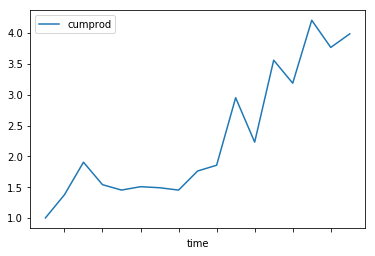

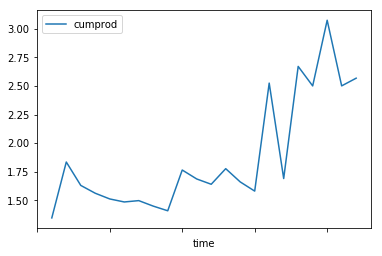

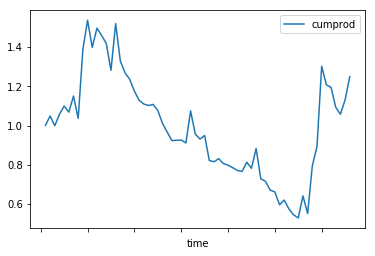

In [155]:
dfside0 = get_macd_rtn(rawdf,12,26,9)
dfside1 = get_macd_rtn(rawdf,14,30,11)
dfside2 = get_macd_rtn(rawdf,6,10,5)

In [147]:
dfside0['net_ret'].describe()

count    17.000000
mean      0.111220
std       0.257319
min      -0.244092
25%      -0.056820
50%       0.037809
75%       0.320513
max       0.595988
Name: net_ret, dtype: float64

In [152]:
dfside0[dfside0['net_ret']>0].count()

time       0.555556
close      0.555556
side       0.555556
return     0.588235
net_ret    0.588235
percent    0.588235
cumprod    0.588235
dtype: float64

In [114]:
sides0['cumprod'] = sides0['percent'].cumprod()
sides0

C:\Users\Taichen\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,time,close,side,return,net_ret,percent,cumprod
38,2020-02-08,9895.05,1,NaN,NaN,NaN,NaN
45,2020-02-15,9904.72,-1,0.000977,0.000977,1.000977,1.000977
80,2020-03-21,6186.98,1,-0.375350,0.375350,1.375350,1.376694
131,2020-05-11,8561.52,-1,0.383796,0.383796,1.383796,1.905065
152,2020-06-01,10200.77,1,0.191467,-0.191467,0.808533,1.540307
156,2020-06-05,9621.16,-1,-0.056820,-0.056820,0.943180,1.452787
188,2020-07-07,9257.39,1,-0.037809,0.037809,1.037809,1.507716
198,2020-07-17,9154.32,-1,-0.011134,-0.011134,0.988866,1.490929
202,2020-07-21,9390.00,1,0.025745,-0.025745,0.974255,1.452545
223,2020-08-11,11392.08,-1,0.213214,0.213214,1.213214,1.762248


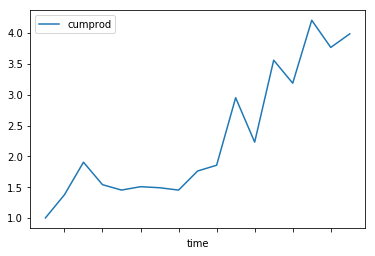

In [135]:
sides0.plot(x='time',y=['cumprod'])

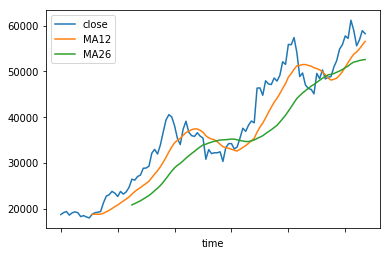

In [16]:
ti.plot(x = 'time',y = ['close','MA12','MA26'])

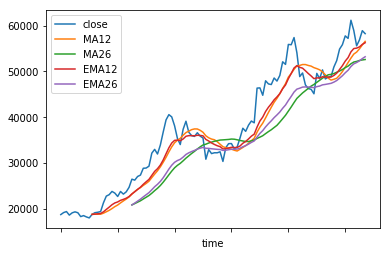

In [18]:
ti.plot(x = 'time', y = ['close', 'MA12', 'MA26', 'EMA12', 'EMA26'])

In [19]:
ti['MACD'] = ti['EMA12'] - ti['EMA26']
ti['MACDSingnal'] = ti['MACD'].transform(lambda x: x.ewm(span=9, adjust=False).mean())

In [21]:
# ti

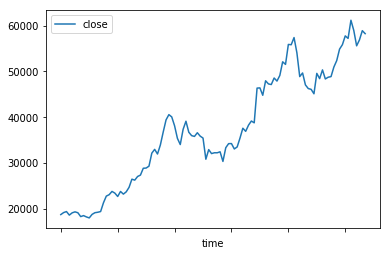

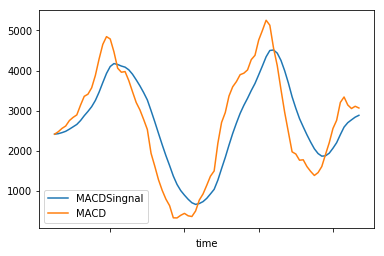

In [22]:
ti.plot(x = 'time', y = ['close'])
ti.plot(x = 'time', y = ['MACDSingnal', 'MACD'])


In [23]:
ti['rsi5'] = talib.RSI(ti['close'],5)
ti['rsi15'] = talib.RSI(ti['close'],15)

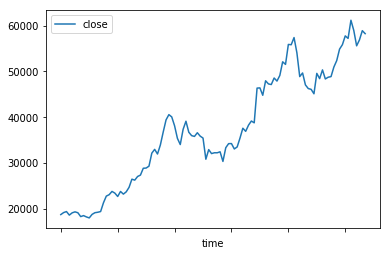

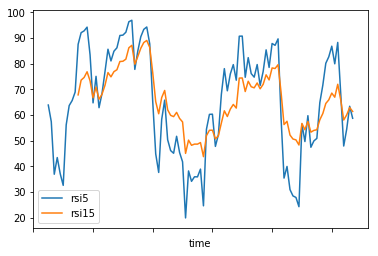

In [24]:
ti.plot(x = 'time', y = ['close'])
ti.plot(x = 'time', y = ['rsi5', 'rsi15'])
